In [1]:
import numpy as np
from plot import plot, plot_one

In [2]:
class Node:
    def __init__(self, value):
        self.value = np.array(value, dtype=np.float32)
        self.grad = np.zeros_like(self.value, np.float32)
        self.inputs = []

    def zero_grad(self):
        self.grad = np.zeros_like(self.value)
        for input, _ in self.inputs:
            input.zero_grad()

    def forward(self):
        for input, _ in self.inputs:
            input.forward()

    def backward(self, upstream_grad=None):
        if upstream_grad is None:
            upstream_grad = np.ones_like(self.value, np.float32)

        self.grad = self.grad + upstream_grad
        for input, grad_fn in self.inputs:
            input_grad = grad_fn(upstream_grad)
            input.backward(input_grad)

    def __add__(self, other):
        return Add(self, other)

    def __sub__(self, other):
        return Subtract(self, other)

    def __mul__(self, other):
        return Multiply(self, other)

    def __matmul__(self, other):
        return MatMultiply(self, other)


class Add(Node):
    def __init__(self, a, b):
        self.inputs = [(a, lambda upstream: upstream), (b, lambda upstream: upstream)]

    def forward(self):
        super().forward()
        self.value = self.inputs[0][0].value + self.inputs[1][0].value

class Subtract(Node):
    def __init__(self, a, b):
        self.inputs = [(a, lambda upstream: upstream), (b, lambda upstream: -upstream)]

    def forward(self):
        super().forward()
        self.value = self.inputs[0][0].value - self.inputs[1][0].value

class Multiply(Node):
    def __init__(self, a, b):
        self.inputs = [
            (a, lambda upstream: upstream * b.value),
            (b, lambda upstream: upstream * a.value),
        ]

    def forward(self):
        super().forward()
        self.value = self.inputs[0][0].value * self.inputs[1][0].value


class MatMultiply(Node):
    def __init__(self, a, b):
        self.inputs = [
            (a, lambda upstream: upstream @ b.value.T),
            (b, lambda upstream: a.value.T @ upstream),
        ]

    def forward(self):  
        super().forward()
        self.value = self.inputs[0][0].value @ self.inputs[1][0].value


class ReLU(Node):
    def __init__(self, x):
        self.inputs = [
            (x, lambda upstream: upstream * (x.value > 0).astype(np.float32))
        ]

    def forward(self):
        super().forward()
        self.value = np.maximum(0, self.inputs[0][0].value)


class Transpose(Node):
    def __init__(self, x):
        self.inputs = [(x, lambda upstream: upstream.T)]

    def forward(self):
        super().forward()
        self.value = self.inputs[0][0].value.T

In [3]:
n_samples = 10000

X = Node(np.random.randn(n_samples, 1) * 2)
y = Node(np.sin(X.value) + np.random.randn(n_samples, 1) * 0.01)


hidden_layer_dim = 10
learning_rate = 0.0001
epochs = 1001
batch_size = 100

input_layer = Node([])
target = Node([])

weights_1 = Node(np.random.randn(X.value.shape[1], hidden_layer_dim))
biases_1 = Node(np.random.randn(1, hidden_layer_dim))
weights_2 = Node(np.random.randn(hidden_layer_dim, 1))
biases_2 = Node(np.random.randn(1, 1))
out_1 = ReLU(input_layer @ weights_1 + biases_1)
out_2 = out_1 @ weights_2 + biases_2
diff = out_2 - target
loss = Transpose(diff) @ diff

y_preds = []
for epoch in range(epochs):
    random_indices = np.random.choice(X.value.shape[0], batch_size, replace=False)
    input_layer.value = X.value[random_indices]
    target.value = y.value[random_indices]
    
    loss.forward()
    loss.zero_grad()
    loss.backward()
    if epoch % (epochs // 10) == 0:
        print(f"Epoch {epoch}: {loss.value / batch_size}")

    if epoch % 5 == 0:
        input_layer.value = X.value
        out_2.forward()
        y_preds.append(out_2.value.flatten())

    weights_1.value -= learning_rate * weights_1.grad
    weights_2.value -= learning_rate * weights_2.grad
    biases_1.value -= learning_rate * biases_1.grad.sum(axis=0)
    biases_2.value -= learning_rate * biases_2.grad.sum(axis=0)


Epoch 0: [[1.0784708]]
Epoch 100: [[0.10001877]]
Epoch 200: [[0.07877761]]
Epoch 300: [[0.09614899]]
Epoch 400: [[0.0629956]]
Epoch 500: [[0.05315482]]
Epoch 600: [[0.04092501]]
Epoch 700: [[0.04060634]]
Epoch 800: [[0.0589853]]
Epoch 900: [[0.03412032]]
Epoch 1000: [[0.04282663]]


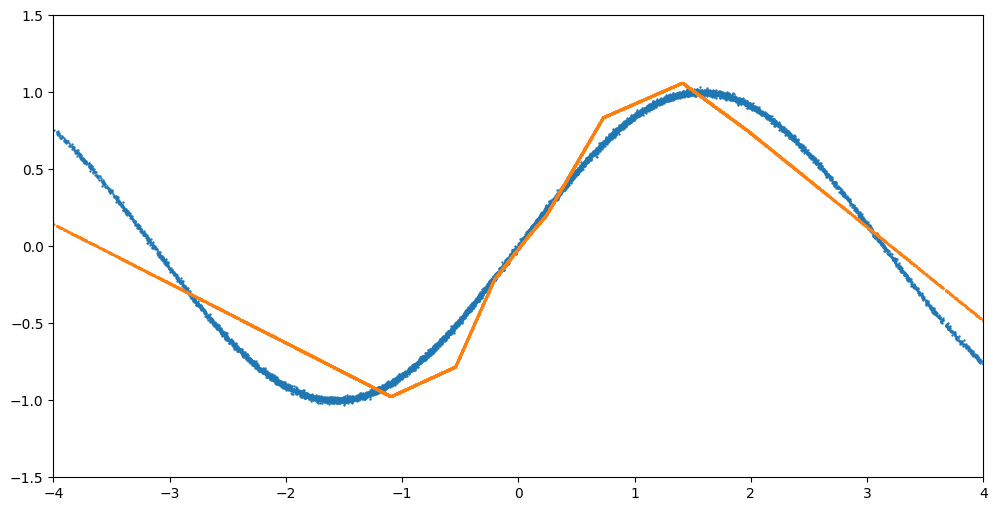

In [4]:
plot_one(X, y, y_preds)

In [5]:
plot(X, y, y_preds)
